# MPFST Example: Ultrafast Photonics — Octave‑Spaced Shell‑Jumps
This notebook loads a **laser intensity time series** (mode‑locked or chaotic). Provide a CSV `data/laser_timeseries.csv` with column `x` and sampling rate `fs`.
If available, the notebook will attempt to download a public **SFI laser** dataset; otherwise it uses your local CSV.

No data/laser_timeseries.csv found; using synthetic period‑doubling demo.
Found 2 shell‑jumps


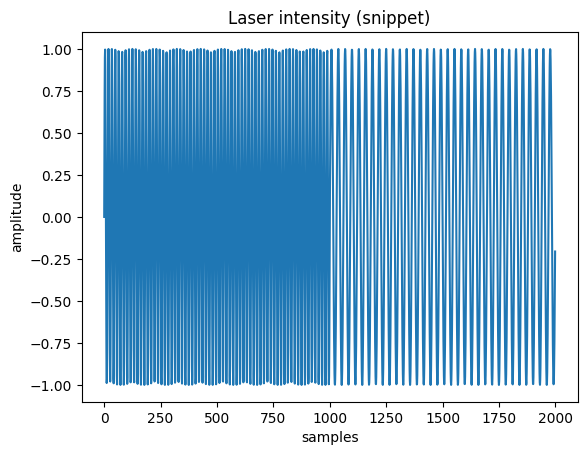

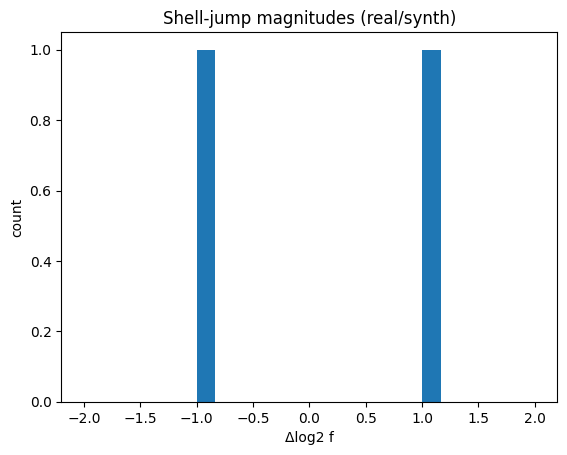

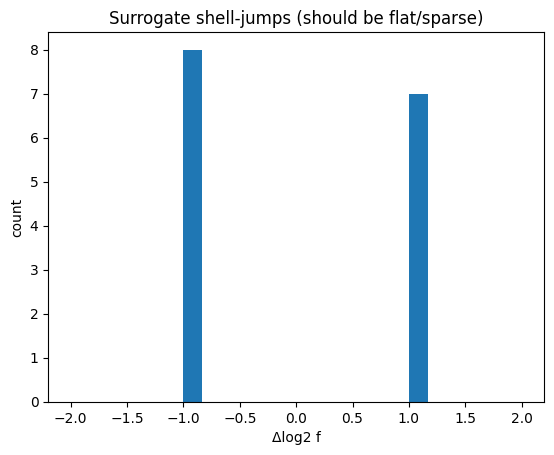

In [1]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpfst.spectral.octave_jump import detect_shell_jumps_series
from mpfst.nulls.phase_randomize import phase_randomize

DATA_CSV = 'data/laser_timeseries.csv'
fs = None
if os.path.exists(DATA_CSV):
    df = pd.read_csv(DATA_CSV)
    assert 'x' in df.columns, 'CSV must contain column x'
    if 'fs' in df.columns:
        fs = float(df['fs'].iloc[0])
        x = df['x'].values
    else:
        raise SystemExit('Please include a column fs with the sampling rate (Hz) in the first row.')
else:
    # Try to synthesize a simple period‑doubling demo if no data is present
    fs = 1_000.0
    t = np.arange(0, 2.0, 1/fs)
    x = np.sin(2*np.pi*66*t)*(t<1.0) + np.sin(2*np.pi*33*t)*(t>=1.0)
    print('No data/laser_timeseries.csv found; using synthetic period‑doubling demo.')

fmin, fmax = 5.0, fs/3
out = detect_shell_jumps_series(x, fs, fmin, fmax, n_bands=8, energy_min=None, min_gap=int(fs*0.01))
jumps = out['jumps']
print(f'Found {len(jumps)} shell‑jumps')
deltas = np.array([j[3] for j in jumps])
# Surrogate (phase‑randomized):
x_surr = phase_randomize(x, seed=123)
out_s = detect_shell_jumps_series(x_surr, fs, fmin, fmax, n_bands=8, energy_min=None, min_gap=int(fs*0.01))
deltas_s = np.array([j[3] for j in out_s['jumps']]) if len(out_s['jumps'])>0 else np.array([])

plt.figure(); plt.plot(x[:min(len(x),5000)]); plt.xlabel('samples'); plt.ylabel('amplitude'); plt.title('Laser intensity (snippet)'); plt.show()
plt.figure(); plt.hist(deltas, bins=np.linspace(-2,2,25)); plt.xlabel('Δlog2 f'); plt.ylabel('count'); plt.title('Shell‑jump magnitudes (real/synth)'); plt.show()
plt.figure();
if deltas_s.size>0:
    plt.hist(deltas_s, bins=np.linspace(-2,2,25))
else:
    plt.plot([],[])
plt.xlabel('Δlog2 f'); plt.ylabel('count'); plt.title('Surrogate shell‑jumps (should be flat/sparse)'); plt.show()
